# MINE4201 - Taller 1: Filtro Colaborativo
# Exploración modelos KNN

Integrantes:
- Alejandro Hernández Sánchez - 202512564
- Diego Leonardo Barón Espitia - 202525657
- Iván David Suarez Ruiz - 202512491
- Juan Diego Yepes Parra - 202022391

In [ ]:
!pip install "numpy>=1.25.0,<2.0.0"
!pip install scikit-surprise
!pip install pandas
!pip install matplotlib

In [44]:
import os
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import random

seed = 10
random.seed(seed)
np.random.seed(seed)


In [45]:
ratings = pd.read_csv('dataset/rating.csv', sep=',', names=['userId', 'movieId', 'rating', 'timestamp'], encoding='latin-1', skiprows=1)

In [46]:
movies = pd.read_csv('dataset/movie.csv', sep=',',  names = [ 'movieId', 'title', 'genres' ] ,encoding='latin-1',skiprows=1)

In [ ]:
movies.describe()

,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


In [48]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [49]:
ratings.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [50]:
ratings[ratings.userId == 1].count()

userId       175
movieId      175
rating       175
timestamp    175
dtype: int64

In [51]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Visualice la distribución de ratings

<Axes: >

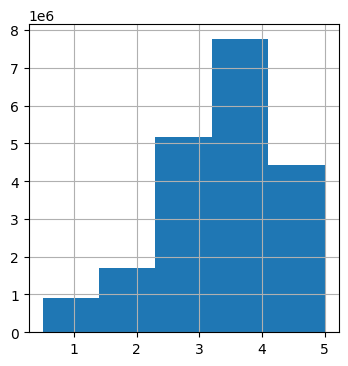

In [52]:
ratings.rating.hist(bins=5, figsize=(4,4))

In [54]:
users_over_500 = ratings.groupby('userId')['rating'].agg({'count'}).sort_values(by='count', ascending=False)
users_over_500 = users_over_500[users_over_500['count'] >= 300]
users_over_500

,count
userId,
118205,9254
8405,7515
82418,5646
121535,5520
125794,5491
...,...
87264,300
48089,300
13184,300


In [ ]:
ratings.groupby('userId')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)

,mean,count
user_id,,
405,1.834464,737
655,2.908029,685
13,3.097484,636
450,3.864815,540
276,3.465251,518
...,...,...
685,2.050000,20
475,3.600000,20
36,3.800000,20


In [ ]:
ratings.groupby('user_id')['rating'].mean().reset_index()

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


## Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

> ¿Cómo es la distribución del número de ratings por usuario?

La mayoría de los usuarios han calificado entre 20 y 50 películas aproximadamente, por lo tanto, el algoritmo deberá entrenarse con poca información. Asimismo, un pequeño porcentaje de usuarios hacen una gran cantidad de calificaciones, por lo tanto, dichos usuarios son muy activos y/o entusiastas.


> ¿Cómo es la distribución del promedio de calificación por usuario?

El comportamiento individual de los usuarios es bastante similar al comporamiento general, ya que también suelen dejar calificaciones de entre 3 y 4 puntos.

Se observa una distribución de promedios de calificación con un sesgo hacia la derecha debido a que la mayoría de los usuarios califican entre 3 y 4 puntos las películas, lo que indica que son usuarios que han tenido una experiencia positiva con el contenido consumido. Asimismo, hay pocos usuarios que califican 1 y 2 que corresponden a usuarios críticos y con estándares de exigencia más elevados.

Text(0, 0.5, 'Frecuencia')

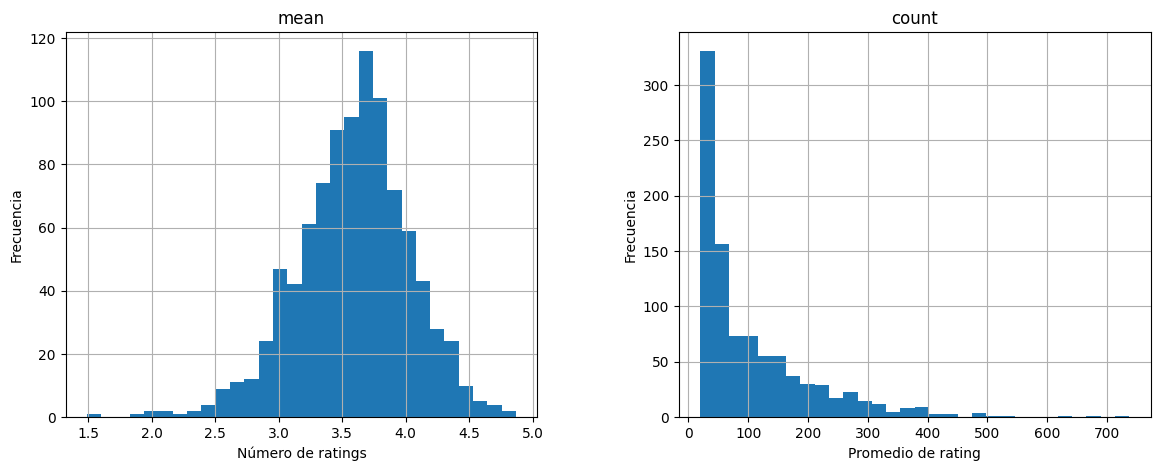

In [ ]:
ax = ratings.groupby('user_id')['rating'].agg({'count','mean'}) \
    .sort_values(by='count', ascending=False) \
    .hist(figsize=(14, 5), bins=30)

ax[0, 0].set_xlabel('Número de ratings')
ax[0, 0].set_ylabel('Frecuencia')
ax[0, 1].set_xlabel('Promedio de rating')
ax[0, 1].set_ylabel('Frecuencia')

## En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones.

In [ ]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

,mean,var,count,movie title
item_id,,,,
1,3.878319,0.860992,452,GoldenEye (1995)
2,3.206107,0.934116,131,Four Rooms (1995)
3,3.033333,1.470787,90,Get Shorty (1995)
4,3.550239,0.931358,209,Copycat (1995)
5,3.302326,0.895759,86,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,1.000000,NaN,1,B. Monkey (1998)
1679,3.000000,NaN,1,Sliding Doors (1998)
1680,2.000000,NaN,1,You So Crazy (1994)


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas



> ¿Cuáles son los items con más calificaciones?  

Legends of the Fall (1994) con 583 calificaciones y con un promedio 4.35 puntos. Le sigue George of the Jungle (1997) con 509 calificaciones y con un promedio de 3.8 en su calificación y en tercer puesto Heavy Metal (1981) con 508 calificaciones y un promedio de 4.15 en su calificación. En quinto puesto esta la película Breakdown (1997) con 485 calificaciones y un promedio de 3.15 en su calificación. Del top 5 de películas es la que tiene la varianza más alta (1.20) a pesar de tener el promedio más bajo. Esto indica que las opiniones sobre esta película están muy polarizadas en comparación con las otras.

> ¿Se puede observar el fenomeno de cola larga en este dataset?

Efectivamente, se puede observar el fenómeno de Cola Larga (Long Tail) en la figura 2. Esto indica que el dataset está dominado por una tendencia a que la mayoría de los usuarios tengan poca actividad, mientras que una minoría (la cola) concentra gran parte de la interacción. Aunque estos usuarios altamente activos podrían parecer outliers, en sistemas de recomendación son fundamentales, ya que actúan como puentes de información. Sin embargo, su exceso de peso puede sesgar el modelo hacia sus gustos específicos, opacando las preferencias de la mayoría casual.
Asimismo, como se observa en la figura 5, al calcular el sesgo de la cantidad de calificaciones por usuario se observa que es mayor a uno, lo que indica un sesgo positivo fuerte sesgado por un grupo minoritario de usuarios altamente activos.

Finalmente, el promedio es más alto que la mediana, por lo tanto, se confirma que se tiene unos "usuarios muy activos" (usuarios con 500, 600 o 700 calificaciones) que están empujando el promedio hacia arriba, es decir, hace que el promedio suba hasta 106, casi 40 puntos por encima de lo que hace el usuario común.





In [ ]:
mt=ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

In [ ]:
mt.sort_values(by='count', ascending=False).head()

,mean,var,count,movie title
item_id,,,,
50,4.358491,0.776762,583,Legends of the Fall (1994)
258,3.803536,0.988885,509,George of the Jungle (1997)
100,4.155512,0.952100,508,Heavy Metal (1981)
181,4.007890,0.853693,507,GoodFellas (1990)
294,3.156701,1.206799,485,Breakdown (1997)


In [ ]:
mt.sort_values(by='count', ascending=False)['count'].skew()

2.3130470435432735

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.


Ver:

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [ ]:
mt.sort_values(by='mean', ascending=False).head(10)

,mean,var,count,movie title
item_id,,,,
814,5.0,NaN,1,One Fine Day (1996)
1599,5.0,NaN,1,Guantanamera (1994)
1201,5.0,NaN,1,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)"
1122,5.0,NaN,1,"Last Time I Saw Paris, The (1954)"
1653,5.0,NaN,1,Chairman of the Board (1998)
1293,5.0,0.0,3,Ayn Rand: A Sense of Life (1997)
1500,5.0,0.0,2,Prisoner of the Mountains (Kavkazsky Plennik) ...
1189,5.0,0.0,3,That Old Feeling (1997)
1536,5.0,NaN,1,Cosi (1996)


> ¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

| Producto | Calificación positiva | Calificación negativa | Promedio positivas |
| --- | --- | --- | --- |
| p1 | 2 | 0 | 100% |
| p2 | 100 | 1 | 99% |

En el anterior escenario hipotético, el promedio simple es injusto: se puntúa más alto al Producto 1 (p1) solo porque tuvo 2 votos, mientras castiga al Producto 2 (p2) que es más popular y confiable. Este enfoque solo mira la calidad (el promedio) pero ignora la cantidad (los votos). Para que las recomendaciones sean honestas, se necesita un método como el Wilson Score, que equilibra ambos valores y solo recomienda productos con éxito comprobado.

> ¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

Si, por ejemplo, usando el método de Lower Bound de Wilson Score. Es una fórmula matemática que "castiga" la incertidumbre cuando hay pocos datos. En lugar de dar un promedio simple, calcula el valor mínimo con el que hay seguridad en ese producto.
El Wilson Score no mira el promedio actual, sino que calcula el límite inferior (el punto más bajo). Si un producto tiene pocas calificaciones, el sistema "desconfía" y le asigna un puntaje bajo por seguridad. Solo cuando recibe muchos votos positivos, el sistema se "convence" y le permite subir en el ranking. Es mejor que la recomendación basada en el promedio porque evita el sesgo de pocos datos y, además, realiza un balance entre calidad y cantidad.
Otro método de creación de listas de recomendación teniendo en cuenta estos dos parámetros es un promedio ponderado, en donde se encuentren los items más populares haciendo un promedio que tenga un rango de confiabilidad que demuestre que varios usuarios apoyan la calificación.


# Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [ ]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

In [ ]:
surprise_dataset.df.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [ ]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [ ]:
train_set.n_ratings

80000

In [ ]:
len(test_set)

20000

In [ ]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html)

El modelo recibe los siguientes parámetros:


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [ ]:
# se crea un modelo knnbasic item-item con similitud coseno
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [ ]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [ ]:
test_predictions=algo.test(test_set)

In [ ]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [ ]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0453


1.0453343976192102

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

> ¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

RMSE Usuario – Usuario:
Bajo los parámetros de k=20, min_k=2 y similitud de Coseno, el modelo presenta un RMSE de 1.0166. Esto indica que, en promedio, las predicciones del sistema se desvían aproximadamente 1 punto (en una escala de 1 a 5) respecto a la calificación real del usuario. Es fundamental notar que, al usar Coseno Simple, el error podría estar influenciado por el sesgo de los usuarios y el tratamiento de los valores faltantes como ceros, lo que tiende a penalizar la precisión.


> ¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario?

Para dar solución a este punto, hemos implementado una búsqueda en grilla explorando diversos valores para los parámetros: 'k': [20, 40, 60, 80, 100], 'min_k': [2, 3, 5] y la métrica de similitud 'cosine'. El objetivo de esta búsqueda fue identificar qué combinación optimiza el RMSE.
Los resultados evidencian que el mejor valor obtenido es un RMSE de 0.9854, bajo la configuración k: 20 y min_k: 2, utilizando un esquema de validación cruzada de cv=3. Este último procedimiento garantiza que el resultado sea estadísticamente más confiable y menos propenso a sesgos derivados de una única división de los datos. Si bien esta cifra es inferior a la obtenida en el experimento anterior, no representa un cambio significativo en términos prácticos, ya que el error se mantiene en un rango muy cercano a 1.0.

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True  # calcule similitud usuario-usuario
               }
algo2 = KNNBasic(k=20, min_k=2, sim_options=sim_options)

algo2.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
test_predictions2=algo2.test(test_set)

In [ ]:
test_predictions2[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.35, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=4.350586293776335, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=3.607980194649977, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.6497107625654204, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=3.8002893050257525, details={'actual_k': 20, 'was_impossible': False})]

In [ ]:
accuracy.rmse( test_predictions2, verbose = True )

RMSE: 1.0166


1.0166414414593592

In [ ]:
param_grid = {
    'k': [20, 40, 60, 80, 100],
    'min_k': [2,3,5],
    'sim_options_4':{
        'name': 'cosine',
        'user_based': [True]
    }
}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=2)

In [ ]:
gs.fit(surprise_dataset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
print(f"Mejor RMSE promedio: {gs.best_score['rmse']}")
print(f"Mejores parámetros: {gs.best_params['rmse']}")

Mejor RMSE promedio: 1.0026896131434881
Mejores parámetros: {'k': 20, 'min_k': 2, 'sim_options_4': 'name'}


## Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [ ]:
#Se crea el dataset para modelo
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [ ]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [ ]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [ ]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [ ]:
# Función para obtener top 10 recomendaciones para un usuario
def get_top_recommendations(user_id, predictions, n=10):
    user_preds = list(filter(lambda x: x[0] == user_id, predictions))
    user_preds.sort(key=lambda x: x.est, reverse=True)
    print(user_preds)
    top_preds = user_preds[:n]

    labels = ['movie id', 'estimation']
    df_preds = pd.DataFrame.from_records(
        list(map(lambda x: (x.iid, x.est), top_preds)),
        columns=labels
    )

    result = df_preds.merge(
        items[['movie id', 'movie title']],
        how='left',
        on='movie id'
    )
    result = result.merge(
        mt[['count', 'mean']],
        left_on='movie id',
        right_index=True,
        how='left'
    )

    return result

In [ ]:
get_top_recommendations(196, user_predictions, 10)

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}), Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}), Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}), Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}), Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}), Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_impossibl

,movie id,estimation,movie title,count,mean
0,1309,4.500000,"Very Natural Thing, A (1974)",1,1.000000
1,1310,4.500000,"Walk in the Sun, A (1945)",1,3.000000
2,1676,4.250000,"War at Home, The (1996)",1,2.000000
3,1675,4.250000,"Sunchaser, The (1996)",1,3.000000
4,1289,4.202436,Jack and Sarah (1995),7,2.142857
5,1643,4.097226,Angel Baby (1995),4,3.750000
6,1593,4.090909,Death in Brunswick (1991),1,4.000000
7,935,4.051367,Paradise Road (1997),7,3.285714
8,1216,4.050692,Kissed (1996),6,3.000000
9,1312,4.049247,"Pompatus of Love, The (1996)",7,3.000000


In [ ]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [ ]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title']], how='left', on='movie id')

,movie id,estimation,movie title
0,1309,4.500000,"Very Natural Thing, A (1974)"
1,1310,4.500000,"Walk in the Sun, A (1945)"
2,1676,4.250000,"War at Home, The (1996)"
3,1675,4.250000,"Sunchaser, The (1996)"
4,1289,4.202436,Jack and Sarah (1995)
5,1643,4.097226,Angel Baby (1995)
6,1593,4.090909,Death in Brunswick (1991)
7,935,4.051367,Paradise Road (1997)
8,1216,4.050692,Kissed (1996)
9,1312,4.049247,"Pompatus of Love, The (1996)"


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

In [ ]:
ratings['user_id'].max()+1

944

In [ ]:
ratings['user_id'].max()+1

944

In [ ]:
# Identificar peliculas populares usando un promedio ponderado (rating + cantidad)
# y peliculas de nicho como las de menor cantidad de ratings.
# Score ponderado: (v/(v+m))*R + (m/(v+m))*C
# https://www.quora.com/How-does-IMDbs-rating-system-work

# Media global de ratings
C = ratings['rating'].mean()
# Umbral de confiabilidad
m = 50

mt_weighted = mt.copy()
mt_weighted['weighted_score'] = (
    (mt_weighted['count'] / (mt_weighted['count'] + m)) * mt_weighted['mean']
    + (m / (mt_weighted['count'] + m)) * C
)

popular_movies = mt_weighted.sort_values(by='weighted_score', ascending=False).head(20)
print("Peliculas mas populares (promedio ponderado):")
print(popular_movies[['movie title', 'count', 'mean', 'weighted_score']].head(20))

print("\n" + "="*80 + "\n")

# Películas de nicho: pocas calificaciones (< 50) pero buen promedio (>= 4.0)
niche_movies = mt[(mt['count'] < 50) & (mt['count'] >= 10) & (mt['mean'] >= 4.0)].sort_values(by='mean', ascending=True)
print("Películas de nicho:")
print(niche_movies[['movie title', 'count', 'mean']].head(20))

Peliculas mas populares (promedio ponderado):
                                         movie title  count      mean  \
item_id                                                                 
318                  Everyone Says I Love You (1996)    298  4.466443   
64                What's Eating Gilbert Grape (1993)    283  4.445230   
483                       Maltese Falcon, The (1941)    243  4.456790   
50                        Legends of the Fall (1994)    583  4.358491   
12                           Mighty Aphrodite (1995)    267  4.385768   
603                     It Happened One Night (1934)    209  4.387560   
98            Snow White and the Seven Dwarfs (1937)    390  4.289744   
127                                  Supercop (1992)    413  4.283293   
408                                      Jack (1996)    112  4.491071   
169                           Cinema Paradiso (1988)    118  4.466102   
174                                    Brazil (1985)    420  4.252381   
357  

In [ ]:
import time
current_timestamp = int(time.time())

mainstream_ratings = []
niche_ratings = []

for index, row in popular_movies.iterrows():
    mainstream_ratings.append([944, index, random.randint(4,5), current_timestamp])

for index, row in niche_movies.iterrows():
    niche_ratings.append([945, index, random.randint(4,5), current_timestamp])

new_ratings_df = pd.DataFrame(mainstream_ratings + niche_ratings,
                               columns=['user_id', 'item_id', 'rating', 'timestamp'])

print("Nuevos ratings para Usuario 944 (Mainstream):")
print(new_ratings_df[new_ratings_df['user_id'] == 944])
print("\nNuevos ratings para Usuario 945 (Nicho):")
print(new_ratings_df[new_ratings_df['user_id'] == 945])

# Agregar las películas calificadas al dataframe original
ratings_with_new_users = pd.concat([ratings, new_ratings_df], ignore_index=True)

print(f"\nTotal de ratings originales: {len(ratings)}")
print(f"Total de ratings con nuevos usuarios: {len(ratings_with_new_users)}")

Nuevos ratings para Usuario 944 (Mainstream):
    user_id  item_id  rating   timestamp
0       944      318       4  1771440131
1       944       64       5  1771440131
2       944      483       5  1771440131
3       944       50       4  1771440131
4       944       12       4  1771440131
5       944      603       5  1771440131
6       944       98       5  1771440131
7       944      127       5  1771440131
8       944      408       4  1771440131
9       944      169       4  1771440131
10      944      174       5  1771440131
11      944      357       5  1771440131
12      944      313       4  1771440131
13      944      427       4  1771440131
14      944      134       5  1771440131
15      944      172       4  1771440131
16      944      480       5  1771440131
17      944      272       4  1771440131
18      944      178       5  1771440131
19      944      474       5  1771440131

Nuevos ratings para Usuario 945 (Nicho):
    user_id  item_id  rating   timestamp
20      94

In [ ]:
# Reentrenar el modelo con los nuevos usuarios
reader = Reader(rating_scale=(1, 5))
surprise_dataset_new = Dataset.load_from_df(ratings_with_new_users[['user_id', 'item_id', 'rating']], reader)
rating_data_new = surprise_dataset_new.build_full_trainset()
test_new = rating_data_new.build_anti_testset()

# Crear y entrenar el modelo item-item con similitud coseno
sim_options = {
    'name': 'cosine',
    'user_based': False  # similitud item-item
}
algo_new = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo_new.fit(rating_data_new)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# Generar predicciones para ambos usuarios
predictions_new = algo_new.test(test_new)


In [ ]:
print("="*80)
print("RECOMENDACIONES PARA USUARIO 944 (Preferencias Mainstream)")
print("="*80)
recs_944 = get_top_recommendations(944, predictions_new, n=10)
recs_944

RECOMENDACIONES PARA USUARIO 944 (Preferencias Mainstream)
[Prediction(uid=944, iid=711, r_ui=3.5302825841405023, est=4.846153846153846, details={'actual_k': 13, 'was_impossible': False}), Prediction(uid=944, iid=1526, r_ui=3.5302825841405023, est=4.785714285714286, details={'actual_k': 14, 'was_impossible': False}), Prediction(uid=944, iid=1677, r_ui=3.5302825841405023, est=4.7272727272727275, details={'actual_k': 11, 'was_impossible': False}), Prediction(uid=944, iid=1674, r_ui=3.5302825841405023, est=4.714285714285714, details={'actual_k': 14, 'was_impossible': False}), Prediction(uid=944, iid=1541, r_ui=3.5302825841405023, est=4.689000215153767, details={'actual_k': 16, 'was_impossible': False}), Prediction(uid=944, iid=599, r_ui=3.5302825841405023, est=4.6875, details={'actual_k': 16, 'was_impossible': False}), Prediction(uid=944, iid=677, r_ui=3.5302825841405023, est=4.6875, details={'actual_k': 16, 'was_impossible': False}), Prediction(uid=944, iid=1201, r_ui=3.5302825841405023,

,movie id,estimation,movie title,count,mean
0,711,4.846154,"Substance of Fire, The (1996)",1,4.0
1,1526,4.785714,Witness (1985),1,4.0
2,1677,4.727273,Sweet Nothing (1995),1,3.0
3,1674,4.714286,Mamma Roma (1962),1,4.0
4,1541,4.689000,"Beans of Egypt, Maine, The (1994)",2,3.5
5,599,4.687500,Police Story 4: Project S (Chao ji ji hua) (1993),1,1.0
6,677,4.687500,Fire on the Mountain (1996),1,3.0
7,1201,4.687500,Marlene Dietrich: Shadow and Light (1996),1,5.0
8,1593,4.666667,Death in Brunswick (1991),1,4.0
9,1414,4.666667,Coldblooded (1995),1,2.0


In [ ]:
print("="*80)
print("RECOMENDACIONES PARA USUARIO 945 (Preferencias de Nicho)")
print("="*80)
recs_945 = get_top_recommendations(945, predictions_new, n=10)
recs_945

RECOMENDACIONES PARA USUARIO 945 (Preferencias de Nicho)
[Prediction(uid=945, iid=1533, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=1472, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=1523, r_ui=3.5302825841405023, est=5, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid=945, iid=973, r_ui=3.5302825841405023, est=5, details={'actual_k': 5, 'was_impossible': False}), Prediction(uid=945, iid=1410, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=1122, r_ui=3.5302825841405023, est=5, details={'actual_k': 5, 'was_impossible': False}), Prediction(uid=945, iid=1604, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=957, r_ui=3.5302825841405023, est=4.888816112499417, details={'actual_k': 9, 'was_impossible': False}), Prediction(uid=945, iid=

,movie id,estimation,movie title,count,mean
0,1533,5.000000,I Don't Want to Talk About It (De eso no se ha...,1,4.00
1,1472,5.000000,"Visitors, The (Visiteurs, Les) (1993)",2,3.50
2,1523,5.000000,"Good Man in Africa, A (1994)",2,3.00
3,973,5.000000,Grateful Dead (1995),4,3.50
4,1410,5.000000,Harlem (1993),4,2.75
5,1122,5.000000,They Made Me a Criminal (1939),1,5.00
6,1604,5.000000,He Walked by Night (1948),1,4.00
7,957,4.888816,Pushing Hands (1992),2,2.00
8,1550,4.857143,Destiny Turns on the Radio (1995),2,3.00
9,1146,4.857143,Calendar Girl (1993),3,2.00


In [ ]:
reader = Reader(rating_scale=(1, 5))
surprise_dataset_new = Dataset.load_from_df(ratings_with_new_users[['user_id', 'item_id', 'rating']], reader)
rating_data_new = surprise_dataset_new.build_full_trainset()
test_new = rating_data_new.build_anti_testset()

# Crear y entrenar el modelo item-item con similitud coseno
sim_options = {
    'name': 'pearson',
    'user_based': True
}
algo_new = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo_new.fit(rating_data_new)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Generar predicciones para ambos usuarios
predictions_new = algo_new.test(test_new)


In [ ]:
print("="*80)
print("RECOMENDACIONES PARA USUARIO 944 (Preferencias Mainstream)")
print("="*80)
recs_944 = get_top_recommendations(944, predictions_new, n=10)
recs_944

RECOMENDACIONES PARA USUARIO 944 (Preferencias Mainstream)
[Prediction(uid=944, iid=884, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=944, iid=1368, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=944, iid=1282, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=944, iid=1367, r_ui=3.5302825841405023, est=4.999999999999999, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=944, iid=1344, r_ui=3.5302825841405023, est=4.680765072422509, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=944, iid=1466, r_ui=3.5302825841405023, est=4.6371083726658435, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid=944, iid=513, r_ui=3.5302825841405023, est=4.593202059310468, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=944, iid=192, r_ui=3.5302825841405023, est=4.59148928530103, details={

,movie id,estimation,movie title,count,mean
0,884,5.000000,Year of the Horse (1997),7,3.285714
1,1368,5.000000,Mina Tannenbaum (1994),6,3.666667
2,1282,5.000000,"Grass Harp, The (1995)",9,3.222222
3,1367,5.000000,Faust (1994),5,4.200000
4,1344,4.680765,"Story of Xinghua, The (1993)",5,3.200000
5,1466,4.637108,Margaret's Museum (1995),6,4.000000
6,513,4.593202,"Third Man, The (1949)",72,4.333333
7,192,4.591489,Raging Bull (1980),116,4.120690
8,113,4.587928,"Horseman on the Roof, The (Hussard sur le toit...",9,4.111111
9,1099,4.568072,"Red Firecracker, Green Firecracker (1994)",13,3.461538


In [ ]:
print("="*80)
print("RECOMENDACIONES PARA USUARIO 945 (Preferencias de Nicho)")
print("="*80)
recs_945 = get_top_recommendations(945, predictions_new, n=10)
recs_945

RECOMENDACIONES PARA USUARIO 945 (Preferencias de Nicho)
[Prediction(uid=945, iid=119, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=851, r_ui=3.5302825841405023, est=5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=624, r_ui=3.5302825841405023, est=4.865322304368726, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=493, r_ui=3.5302825841405023, est=4.766127375573438, details={'actual_k': 11, 'was_impossible': False}), Prediction(uid=945, iid=580, r_ui=3.5302825841405023, est=4.764874481285535, details={'actual_k': 3, 'was_impossible': False}), Prediction(uid=945, iid=522, r_ui=3.5302825841405023, est=4.758453742419655, details={'actual_k': 4, 'was_impossible': False}), Prediction(uid=945, iid=1524, r_ui=3.5302825841405023, est=4.754748488242469, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=945, iid=1298, r_ui=3.5302825841405023, est=4.666666666666667

,movie id,estimation,movie title,count,mean
0,119,5.000000,Maya Lin: A Strong Clear Vision (1994),4,4.500000
1,851,5.000000,Two or Three Things I Know About Her (1966),4,3.750000
2,624,4.865322,"Three Caballeros, The (1945)",22,3.272727
3,493,4.766127,"Thin Man, The (1934)",60,4.150000
4,580,4.764874,"Englishman Who Went Up a Hill, But Came Down a...",32,3.375000
5,522,4.758454,Down by Law (1986),35,3.771429
6,1524,4.754748,Kaspar Hauser (1993),8,4.250000
7,1298,4.666667,"Band Wagon, The (1953)",9,3.666667
8,114,4.646460,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761
9,1111,4.643479,Double Happiness (1994),7,3.428571


> ¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

En el primer modelo, podemos ver que aunque el usuario que tiene gustos por películas populares, el modelo no está recomendandole películas de este estilo (con varias recomendaciones), sino que le muestra peliculas bastante nicho. Por otro lado, al usuario con gustos de nicho si se le recomiendan más películas de este estilo.

Puede que esto se deba a que ambos usuarios tienen muy pocos reviews (solo 20), pero consideramos que se debe en gran medida a que se utiliza similitud coseno (y no similitud coseno ajustada), ya que las películas populares tendrían vectores más variados y por tanto menos similitudes, y las películas nicho tienen mucha menos variabilidad y por tanto mejor similitud.

Finalmente, dado que este dataset presenta el fenómeno de cola larga, esto afecta el resultado del modelo de recomendación al utilizar similitud coseno, puesto que la mayoría de la matriz está en 0; lo que implica que se intuye que no les gustaría este item.

> ¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

Para el primer modelo, podria considerarse que casi todas las películas en el dataset son de nicho. Si lo vemos desde esta perspectiva únicamente, el modelo está haciendo un buen trabajo, porque al usar similitud coseno se buscan items donde nos interesa la magnitud de la calificación, y se recomiendan en su mayoría, películas con altos pero pocos ratings.